# Notes
- Different species
- Gap phase replacement
- Spatial field

# To-do
- Inform initial spatial and size distributions
- Inform reproductive mechanism (range, probability, etc.)
- Inform mortality mechanism
- Make the viewer more interactive (zoom and move around, play, reverse, speed up, slow down)
- ~~Write your own quadtree class and add a method for removing objects from it to speed up collision detection~~
- ~~Implement plant reproduction (either as a method in the Plant class or in the Simulation class)~~
- ~~Fix new plant spawns showing up for one frame and then getting killed~~
- ~~Add find collisions to Simulation class~~
- ~~Move plants list and states list to Simulation class~~
- ~~Fix Plant .kill() method~~
- ~~replace .update_color() method to set_color() in Plant class~~
- ~~add simulation.step() method to Simulation class~~

We want to ensure that the initial area per plant is constant regardless of how many plants we start with. Our simulation domain in our arbitrary units ($u$) has an area of
$$A_\mathrm{sim} = Y \,u^2,$$
where $Y$ is a floating point number. Now, if we want $X$ $\mathrm{m}^2$ per plant, and we have $N$ plants that gives a total area of
$$A_\mathrm{real} = N X \,\mathrm{m}^2,$$
where $N$ is an integer and $X$ is a floating point number. Thus the conversion factor from our arbitrary units $u$ to meters $\mathrm{m}$ can be obtained
$$\begin{align}
1 = \frac{A_\mathrm{sim}}{A_\mathrm{real}} &= \frac{Y}{N X}\frac{u^2}{\mathrm{m}^2}\\
\frac{\mathrm{m}}{u} &= \sqrt{\frac{Y}{NX}}.
\end{align}$$

If we for example have a domain with area $A_\mathrm{sim} = Y \, u^2 = 1 \, u^2$ and we have $N = 10\,000$ plants which each with $X = 100 \, \mathrm{m^2}$ allocated, we get a conversion factor of
$$\begin{align}
    1 \, \mathrm{m} = \sqrt{\frac{1}{10\,000 \cdot 100}} \, u = \sqrt{10^{-6}} = 10^{-3} \, u
\end{align}$$

In [4]:
import numpy as np
import matplotlib.pyplot as plt

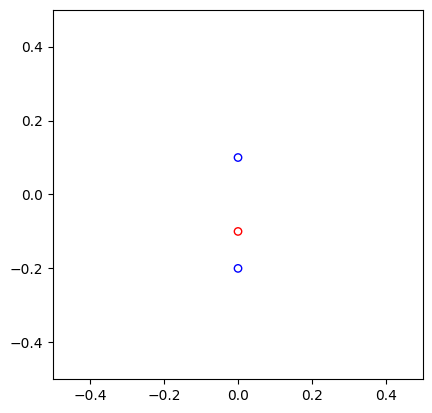

indices = [0, 1]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01), (array([ 0. , -0.1]), 0.01)]
[(array([ 0. , -0.2]), 0.01), (array([0. , 0.1]), 0.01)]
[False False]
no collision
1


In [84]:
from plant import Plant

def check_pos_collision(pos, plant):
    return np.sum((pos - plant.pos) ** 2) < plant.r ** 2

plant_kwargs = {
    'r_min': 0.01,
    'r_max': 30,
    'growth_rate': 0.01,
    'reproduction_range': 100,
    'reproduction_chance': 0.025,
}



plants = [Plant(np.array([0, -0.2]), **plant_kwargs), Plant(np.array([0, 0.1]), **plant_kwargs), Plant(np.array([0.0, -0.1]), **plant_kwargs)]
this_plant = plants[-1]

fig, ax = plt.subplots()
for plant in plants:
    ec = 'r' if plant == this_plant else 'b'
    circle = plt.Circle(plant.pos, plant.r, edgecolor=ec, facecolor='none')
    ax.add_patch(circle)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal', 'box')
plt.show()

indices = [j for j, other in enumerate(plants) if other != this_plant]
print(f'{indices = }')
plants_nearby = [plants[i] for i in indices]
print([(plant.pos, plant.r) for plant in plants])
print([(plant.pos, plant.r) for plant in plants_nearby])

collisions_nearby = np.array([check_pos_collision(this_plant.pos, plant) for plant in plants_nearby])
print(collisions_nearby)

p = None
if len(plants_nearby) == 0:
    p =  0
elif collisions_nearby.any():
    print('collision')
    p =  0
else:
    print('no collision')
    p = 1
    
print(p)